# CSC3022: Reinforcement Learning
## Lab 2: Monte Carlo Methods 

### Background
Monte Carlo (MC) methods are a class of algorithms for learning from experience. Unlike dynamic programming methods, Monte Carlo methods do not require complete knowledge of the environment and can learn directly from interaction with the environment. The key idea is to estimate expected returns by averaging sample returns from actual or simulated episodes of experience.
There are two main variants of Monte Carlo methods for policy evaluation:

1. First-visit MC: Averages the returns following the first visit to a state in an episode
2. Every-visit MC: Averages the returns following every visit to a state in an episode

In this lab, we'll implement both methods, analyze their properties, and apply them to classic reinforcement learning problems.

**Environment:**

We will be using a simple $4 \times 4$ grid world environment. The agent can move in four directions: Up, Down, Left, Right. Some states are terminal. The reward structure is as follows:

* Reaching the goal state (top-left corner) yields a reward of +10.
* All other transitions yield a reward of -1.
* The agent starts at the bottom-right corner.

The state space can be represented by the coordinates $(row, column)$, where $0 \le row, column < 4$. The goal state is $(0, 0)$ and the starting state is $(3, 3)$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


In [3]:
# DO NOT CHANGE
class GridWorld:
    def __init__(self, rows=4, cols=4, start=(3, 3), goal=(0, 0)):
        self.rows = rows
        self.cols = cols
        self.start_state = start
        self.goal_state = goal
        self.current_state = start
        self.actions = ['U', 'D', 'L', 'R']

    def reset(self):
        self.current_state = self.start_state
        return self.current_state

    def step(self, action):
        row, col = self.current_state
        if action == 'U':
            next_row = max(0, row - 1)
            next_col = col
        elif action == 'D':
            next_row = min(self.rows - 1, row + 1)
            next_col = col
        elif action == 'L':
            next_col = max(0, col - 1)
            next_row = row
        elif action == 'R':
            next_col = min(self.cols - 1, col + 1)
            next_row = row
        else:
            raise ValueError("Invalid action")

        self.current_state = (next_row, next_col)
        reward = 10 if self.current_state == self.goal_state else -1
        done = (self.current_state == self.goal_state)
        return self.current_state, reward, done

    def get_possible_actions(self, state):
        return self.actions

    def render(self):
        for r in range(self.rows):
            for c in range(self.cols):
                if (r, c) == self.current_state:
                    print("A", end="\t")
                elif (r, c) == self.goal_state:
                    print("G", end="\t")
                elif (r, c) == self.start_state and (r, c) != self.current_state:
                    print("S", end="\t")
                else:
                    print(".", end="\t")
            print()


In [4]:
# Visualize the value function
# DO NOT CHANGE
def plot_value_function(V, title="Value Function"):
    grid = np.zeros((env.rows, env.cols))
    for state, value in V.items():
        grid[state[0], state[1]] = value

    plt.imshow(grid, cmap='viridis')
    plt.colorbar(label='Value')
    for i in range(env.rows):
        for j in range(env.cols):
            plt.text(j, i, f"{grid[i, j]:.2f}", ha="center", va="center", color="w")
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.show()

In [5]:
# Initialize the environment
env = GridWorld()

In [6]:
# Helper function to generate an episode using a given policy (random policy for now)
# DO NOT CHANGE
def generate_episode(env, policy=None):
    episode = []
    state = env.reset()
    done = False
    while not done:
        if policy is None:
            # Choose a random action
            action = np.random.choice(env.get_possible_actions(state))
        else:
            action = policy[state]
        next_state, reward, done = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode



In [7]:
# Generate a set of episodes to be used by both MC methods: Set the number of episodes
num_episodes_shared = 500 # Try different value
shared_episodes = [generate_episode(env) for _ in range(num_episodes_shared)]

print(f"Generated {len(shared_episodes)} episodes for shared use.")
# Let's look at the first episode
print(f"First shared episode: {shared_episodes[0]}")

Generated 500 episodes for shared use.
First shared episode: [((3, 3), 'R', -1), ((3, 3), 'D', -1), ((3, 3), 'R', -1), ((3, 3), 'R', -1), ((3, 3), 'U', -1), ((2, 3), 'D', -1), ((3, 3), 'L', -1), ((3, 2), 'D', -1), ((3, 2), 'L', -1), ((3, 1), 'D', -1), ((3, 1), 'R', -1), ((3, 2), 'D', -1), ((3, 2), 'D', -1), ((3, 2), 'D', -1), ((3, 2), 'D', -1), ((3, 2), 'U', -1), ((2, 2), 'D', -1), ((3, 2), 'R', -1), ((3, 3), 'D', -1), ((3, 3), 'L', -1), ((3, 2), 'L', -1), ((3, 1), 'R', -1), ((3, 2), 'L', -1), ((3, 1), 'U', -1), ((2, 1), 'D', -1), ((3, 1), 'L', -1), ((3, 0), 'U', -1), ((2, 0), 'D', -1), ((3, 0), 'U', -1), ((2, 0), 'U', -1), ((1, 0), 'U', 10)]


In [ ]:
# 1. First-Visit Monte Carlo Prediction (using shared episodes)

def first_visit_mc_prediction_shared(env, episodes, gamma=1.0):
    """
    Implements First-Visit Monte Carlo prediction using a provided list of episodes.

    Args:
        env: The environment object (not strictly needed here as episodes are pre-generated).
        episodes: A list of episodes, where each episode is a list of (state, action, reward) tuples.
        gamma: The discount factor.

    Returns:
        V: A dictionary mapping each state to its estimated value.
    """
    V = defaultdict(float)
    N = defaultdict(int)  # Count of first visits to each state

    for i_episode, episode in enumerate(episodes):
        visited_states = set()
        G = 0  # Initialize return
        

        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            # Calculate return 
            if state not in visited_states:
                
                # Add state that has been visited to visited states
                visited_states.add(state)
                # Update the count of first visits to each state 
                N[state] += 1
                # Updatecount of first visits to each state
                
                # Update the value of the state 
                G = reward * (gamma ** t)
                V[state] += G
                # print(N[state], G, state)

        if (i_episode + 1) % 1000 == 0:
            print(f"\rProcessing episode {i_episode + 1}/{len(episodes)}", end="")
    
    for state, value in V.items():
        # print(state, value)
        V[state] = value/N[state]
    
    return V





First-Visit Monte Carlo Value Function (using shared episodes):
State (1, 0): 7.3042
State (2, 0): -1.0000
State (3, 0): -1.0000
State (3, 1): -1.0000
State (2, 1): -1.0000
State (3, 2): -1.0000
State (3, 3): -1.0000
State (2, 2): -1.0000
State (2, 3): -1.0000
State (0, 1): 6.2500
State (1, 1): -1.0000
State (1, 2): -1.0000
State (1, 3): -1.0000
State (0, 2): -1.0000
State (0, 3): -1.0000


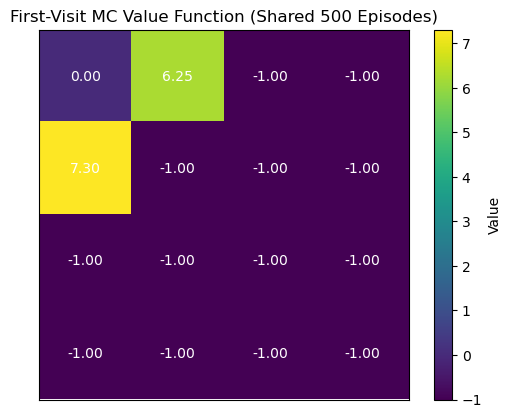

In [27]:
# Run First-Visit MC Prediction using the shared episodes
V_fv_shared = first_visit_mc_prediction_shared(env, shared_episodes)

print("\n\nFirst-Visit Monte Carlo Value Function (using shared episodes):")
for state, value in V_fv_shared.items():
    print(f"State {state}: {value:.4f}")



plot_value_function(V_fv_shared, title=f"First-Visit MC Value Function (Shared {len(shared_episodes)} Episodes)")


In [ ]:
# 2. Every-Visit Monte Carlo Prediction (using shared episodes)

def every_visit_mc_prediction_shared(env, episodes, gamma=1.0):
    """
    Implements Every-Visit Monte Carlo prediction using a provided list of episodes.

    Args:
        env: The environment object (not strictly needed here as episodes are pre-generated).
        episodes: A list of episodes, where each episode is a list of (state, action, reward) tuples.
        gamma: The discount factor.

    Returns:
        V: A dictionary mapping each state to its estimated value.
    """
    V = defaultdict(float)
    N = defaultdict(int)  # Count of visits to each state

    for i_episode, episode in enumerate(episodes):
        G = 0  # Initialize return
        state_action_reward_sequence = episode

        for t in range(len(state_action_reward_sequence) - 1, -1, -1):
            state, action, reward = state_action_reward_sequence[t]
            # Calculate return G
            G = reward * (gamma ** t)
            N[state] += 1
            V[state] += G
            
            # Add state that has been visited to visited states

            # Update the count of visits to each state 

            # Update the value of the state 


        if (i_episode + 1) % 1000 == 0:
            print(f"\rProcessing episode {i_episode + 1}/{len(episodes)}", end="")

    for state, value in V.items():
        V[state] = value/N[state]

    return V



10 (1, 0) 30
-1 (2, 0) 29
-1 (3, 0) 28
-1 (2, 0) 27
-1 (3, 0) 26
-1 (3, 1) 25
-1 (2, 1) 24
-1 (3, 1) 23
-1 (3, 2) 22
-1 (3, 1) 21
-1 (3, 2) 20
-1 (3, 3) 19
-1 (3, 3) 18
-1 (3, 2) 17
-1 (2, 2) 16
-1 (3, 2) 15
-1 (3, 2) 14
-1 (3, 2) 13
-1 (3, 2) 12
-1 (3, 2) 11
-1 (3, 1) 10
-1 (3, 1) 9
-1 (3, 2) 8
-1 (3, 2) 7
-1 (3, 3) 6
-1 (2, 3) 5
-1 (3, 3) 4
-1 (3, 3) 3
-1 (3, 3) 2
-1 (3, 3) 1
-1 (3, 3) 0
10 (0, 1) 54
-1 (1, 1) 53
-1 (2, 1) 52
-1 (2, 2) 51
-1 (1, 2) 50
-1 (1, 3) 49
-1 (1, 2) 48
-1 (2, 2) 47
-1 (3, 2) 46
-1 (3, 1) 45
-1 (3, 2) 44
-1 (3, 2) 43
-1 (3, 3) 42
-1 (3, 3) 41
-1 (3, 2) 40
-1 (2, 2) 39
-1 (3, 2) 38
-1 (3, 2) 37
-1 (2, 2) 36
-1 (1, 2) 35
-1 (0, 2) 34
-1 (0, 3) 33
-1 (0, 3) 32
-1 (1, 3) 31
-1 (2, 3) 30
-1 (2, 3) 29
-1 (2, 2) 28
-1 (3, 2) 27
-1 (2, 2) 26
-1 (1, 2) 25
-1 (1, 3) 24
-1 (2, 3) 23
-1 (3, 3) 22
-1 (3, 3) 21
-1 (3, 3) 20
-1 (2, 3) 19
-1 (2, 3) 18
-1 (1, 3) 17
-1 (0, 3) 16
-1 (0, 2) 15
-1 (0, 2) 14
-1 (1, 2) 13
-1 (1, 3) 12
-1 (2, 3) 11
-1 (3, 3) 10
-1 (3, 3) 9
-1 (2, 3) 

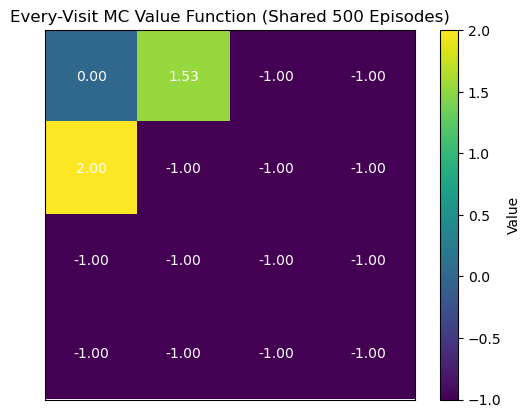

In [34]:
# Run Every-Visit MC Prediction using the shared episodes
V_ev_shared = every_visit_mc_prediction_shared(env, shared_episodes)

print("\n\nEvery-Visit Monte Carlo Value Function (using shared episodes):")
for state, value in V_ev_shared.items():
    print(f"State {state}: {value:.4f}")

# Visualize the value function
plot_value_function(V_ev_shared, title=f"Every-Visit MC Value Function (Shared {len(shared_episodes)} Episodes)")

In [35]:
# 3. Comparison and Analysis (using results from shared episodes)

# Compare the value functions obtained by First-Visit and Every-Visit MC using the same episodes
print("\nComparison of First-Visit and Every-Visit MC Value Functions (using shared episodes):")
for state in set(V_fv_shared.keys()) | set(V_ev_shared.keys()):
    value_fv = V_fv_shared.get(state, 0.0)
    value_ev = V_ev_shared.get(state, 0.0)
    print(f"State {state}: First-Visit = {value_fv:.4f}, Every-Visit = {value_ev:.4f}")


Comparison of First-Visit and Every-Visit MC Value Functions (using shared episodes):
State (0, 1): First-Visit = 6.2500, Every-Visit = 1.5343
State (1, 2): First-Visit = -1.0000, Every-Visit = -1.0000
State (2, 1): First-Visit = -1.0000, Every-Visit = -1.0000
State (3, 1): First-Visit = -1.0000, Every-Visit = -1.0000
State (0, 2): First-Visit = -1.0000, Every-Visit = -1.0000
State (2, 2): First-Visit = -1.0000, Every-Visit = -1.0000
State (1, 0): First-Visit = 7.3042, Every-Visit = 2.0020
State (3, 2): First-Visit = -1.0000, Every-Visit = -1.0000
State (1, 3): First-Visit = -1.0000, Every-Visit = -1.0000
State (1, 1): First-Visit = -1.0000, Every-Visit = -1.0000
State (0, 3): First-Visit = -1.0000, Every-Visit = -1.0000
State (2, 0): First-Visit = -1.0000, Every-Visit = -1.0000
State (3, 0): First-Visit = -1.0000, Every-Visit = -1.0000
State (2, 3): First-Visit = -1.0000, Every-Visit = -1.0000
State (3, 3): First-Visit = -1.0000, Every-Visit = -1.0000
